In [33]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import ccf, grangercausalitytests
from statsmodels.tsa.api import SARIMAX

In [34]:
palette_tab10 = sns.color_palette("tab10", 10)
cmap = sns.color_palette([palette_tab10[0], palette_tab10[1]], as_cmap=True)
cmap

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725)]

Read the data

In [35]:
DIR_SUBJECT_1 = '../udataset/meat/production.csv'
# DIR_SUBJECT_1 = '../udataset/meat/cold_storage.csv'
# DIR_SUBJECT_1 = '../udataset/meat/slaughter.csv'
# DIR_SUBJECT_1 = '../udataset/meat/weights.csv'
df_subject1 = pd.read_csv(DIR_SUBJECT_1)

In [36]:
# DIR_SUBJECT_2 = '../udataset/unemployment_month_US.csv'
# DIR_SUBJECT_2 = '../dataset/youth_unemployment_rate.csv'
DIR_SUBJECT_2 = '../dataset/national_hourly_earnings.csv'
df_subject2 = pd.read_csv(DIR_SUBJECT_2)
df_subject2

,YearMonth,HourlyEarnings
0,2006-03,20.07
1,2006-04,20.36
2,2006-05,20.06
3,2006-06,20.04
4,2006-07,20.28
...,...,...
212,2023-11,34.08
213,2023-12,34.26
214,2024-01,34.67
215,2024-02,34.61


Make variables for specific dataset 1

In [37]:
# For meat production
df_subject1 = df_subject1.drop(columns=['Other Chicken'])
df_subject1 = df_subject1.dropna()
MEAT_TYPE = ['beef', 'veal', 'pork', 'lamb_and_mutton', 'broiler', 'turkey', 'red_meat', 'poultry']
SUBJECT1 = 'meat_production'
UNIT = 'Pounds'

# For meat cold storage
# MEAT_TYPE = ['beef', 'veal', 'pork', 'lamb_and_mutton', 'broiler', 'turkey', 'frozen_egg', 'red_meat', 'poultry']

SUBJECT_TITLE1 = SUBJECT1.replace('_', ' ').title()
df_subject1

,DateTime,Beef,Veal,Pork,Lamb and Mutton,Broiler,Turkey,Red Meat,Poultry
648,1977-01,1.976000e+09,50000000.0,9.770000e+08,28000000.0,7.138000e+08,146500000.0,3.031000e+09,8.603000e+08
649,1977-02,1.847000e+09,47000000.0,9.680000e+08,26000000.0,6.592000e+08,70500000.0,2.888000e+09,7.297000e+08
650,1977-03,2.041000e+09,53000000.0,1.206000e+09,33000000.0,7.832000e+08,58700000.0,3.333000e+09,8.419000e+08
651,1977-04,1.856000e+09,44000000.0,1.077000e+09,30000000.0,7.449000e+08,80300000.0,3.007000e+09,8.252000e+08
652,1977-05,1.864000e+09,43000000.0,1.003000e+09,25000000.0,8.099000e+08,78900000.0,2.935000e+09,8.888000e+08
...,...,...,...,...,...,...,...,...,...
1207,2023-08,2.329500e+09,4100000.0,2.282400e+09,8900000.0,4.156700e+09,433500000.0,4.624900e+09,4.641300e+09
1208,2023-09,2.114600e+09,3500000.0,2.175500e+09,8600000.0,3.805500e+09,489200000.0,4.302200e+09,4.343100e+09
1209,2023-10,2.300800e+09,4000000.0,2.406200e+09,9800000.0,4.177300e+09,431200000.0,4.720800e+09,4.659100e+09
1210,2023-11,2.247300e+09,4100000.0,2.377400e+09,10100000.0,3.817300e+09,500300000.0,4.638900e+09,4.362100e+09


Make variables for specific dataset 2

In [38]:
# # For unemployment_month_US.csv
# df_subject2 = df_subject2.rename(columns={'Year-Month': 'datetime'})
# SUBJECT2 = 'unemployment_rate'

# # For youth_unemployment_rate.csv
# df_subject2 = df_subject2.rename(columns={'YearMonth': 'datetime', 'UnemploymentRate': 'unemployment_rate'})
# SUBJECT2 = 'unemployment_rate'

# For national_hourly_earnings.csv
df_subject2 = df_subject2.rename(columns={'YearMonth': 'datetime', 'HourlyEarnings': 'hourly_earnings'})
SUBJECT2 = 'hourly_earnings'

SUBJECT_TITLE2 = SUBJECT2.replace('_', ' ').title()
df_subject2

,datetime,hourly_earnings
0,2006-03,20.07
1,2006-04,20.36
2,2006-05,20.06
3,2006-06,20.04
4,2006-07,20.28
...,...,...
212,2023-11,34.08
213,2023-12,34.26
214,2024-01,34.67
215,2024-02,34.61


Change label format to be lower + underscores instead of space

In [39]:
df_subject1.columns = df_subject1.columns.str.lower().str.replace(' ', '_')
df_subject2.columns = df_subject2.columns.str.lower().str.replace(' ', '_')

Change date format to better use together

In [40]:
df_subject1['datetime'] = pd.to_datetime(df_subject1['datetime'])
df_subject2['datetime'] = pd.to_datetime(df_subject2['datetime'])
df_subject1 = df_subject1[df_subject1['datetime'].dt.year >= 1983]
df_subject2

,datetime,hourly_earnings
0,2006-03-01,20.07
1,2006-04-01,20.36
2,2006-05-01,20.06
3,2006-06-01,20.04
4,2006-07-01,20.28
...,...,...
212,2023-11-01,34.08
213,2023-12-01,34.26
214,2024-01-01,34.67
215,2024-02-01,34.61


In [41]:
df_subject1 = df_subject1.iloc[::-1]
df_subject1.reset_index(drop=True, inplace=True)
df_subject1

,datetime,beef,veal,pork,lamb_and_mutton,broiler,turkey,red_meat,poultry
0,2023-12-01,2.158900e+09,3700000.0,2.332400e+09,9500000.0,3.615000e+09,449200000.0,4.504500e+09,4.105700e+09
1,2023-11-01,2.247300e+09,4100000.0,2.377400e+09,10100000.0,3.817300e+09,500300000.0,4.638900e+09,4.362100e+09
2,2023-10-01,2.300800e+09,4000000.0,2.406200e+09,9800000.0,4.177300e+09,431200000.0,4.720800e+09,4.659100e+09
3,2023-09-01,2.114600e+09,3500000.0,2.175500e+09,8600000.0,3.805500e+09,489200000.0,4.302200e+09,4.343100e+09
4,2023-08-01,2.329500e+09,4100000.0,2.282400e+09,8900000.0,4.156700e+09,433500000.0,4.624900e+09,4.641300e+09
...,...,...,...,...,...,...,...,...,...
487,1983-05-01,1.783000e+09,27000000.0,1.208000e+09,29000000.0,1.096300e+09,166500000.0,3.047000e+09,1.262800e+09
488,1983-04-01,1.650000e+09,26000000.0,1.227000e+09,29000000.0,1.054300e+09,182700000.0,2.932000e+09,1.237000e+09
489,1983-03-01,1.808000e+09,32000000.0,1.265000e+09,36000000.0,1.106200e+09,135500000.0,3.141000e+09,1.241700e+09
490,1983-02-01,1.632000e+09,26000000.0,9.880000e+08,26000000.0,9.336000e+08,144100000.0,2.672000e+09,1.077700e+09


Plot meat data

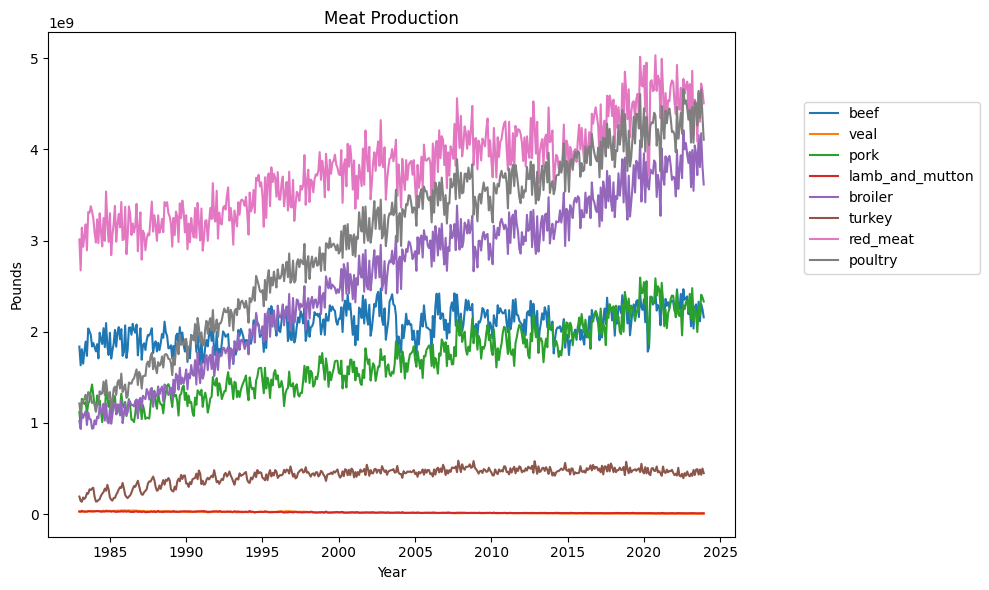

In [42]:
df_temp = pd.melt(df_subject1, id_vars='datetime', var_name='meat', value_name='amount')
plt.figure(figsize=(10, 6))
ax = sns.lineplot(data=df_temp, x='datetime', y='amount', hue='meat')
ax.set_title(SUBJECT_TITLE1)
ax.set_xlabel('Year')
ax.set_ylabel(UNIT)
ax.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=5)
# ax2 = ax.twinx()
# sns.lineplot(data=df_subject2, x='datetime', y=SUBJECT2, color='black', label=f'{SUBJECT_TITLE2} (%)', ax=ax2)
# ax2.set_ylabel(f'{SUBJECT_TITLE2} Rate (%)')

plt.tight_layout()
plt.show()

Plot subject data

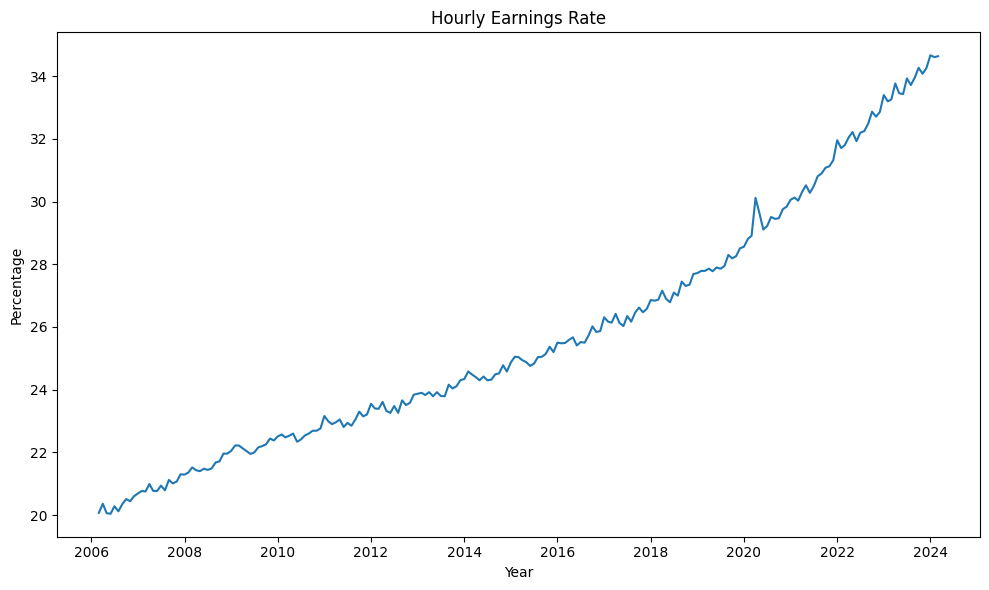

In [43]:
plt.figure(figsize=(10, 6))
ax = sns.lineplot(data=df_subject2, x='datetime', y=SUBJECT2)
ax.set_title(f'{SUBJECT_TITLE2} Rate')
ax.set_xlabel('Year')
ax.set_ylabel('Percentage')
plt.tight_layout()
plt.show()

Calculate and plot rolling mean and std for meat

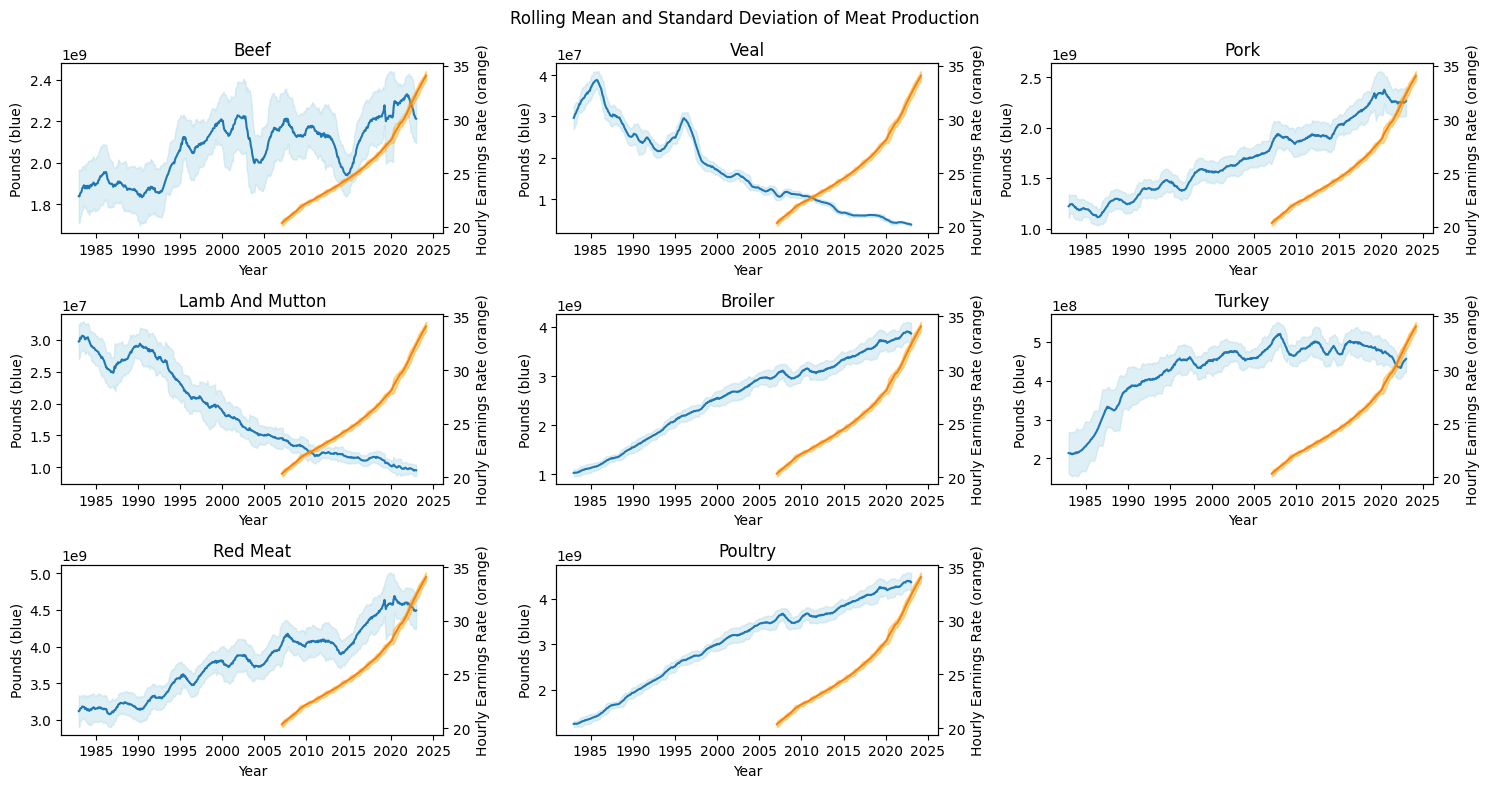

In [44]:
df_temp = df_subject1.copy()
for meat in MEAT_TYPE:
    df_temp[f'rolling_mean_{meat}'] = df_temp[meat].rolling(window=12).mean()
    df_temp[f'rolling_std_{meat}'] = df_temp[meat].rolling(window=12).std()
df_temp = df_temp.dropna()

df_temp2 = df_subject2.copy()
df_temp2['rolling_mean'] = df_temp2[SUBJECT2].rolling(window=12).mean()
df_temp2['rolling_std'] = df_temp2[SUBJECT2].rolling(window=12).std()
df_temp2 = df_temp2.dropna()

plt.figure(figsize=(15, 8))
plt.suptitle('Rolling Mean and Standard Deviation of Meat Production')
for i, meat in enumerate(MEAT_TYPE):
    mean_meat = df_temp[f'rolling_mean_{meat}']
    std_meat = df_temp[f'rolling_std_{meat}']
    ax = plt.subplot(3, 3, i+1)
    sns.lineplot(data=df_temp, x='datetime', y=f'rolling_mean_{meat}', color=cmap[0], label='', ax=ax)
    ax.fill_between(df_temp['datetime'], mean_meat-std_meat, mean_meat+std_meat, color='lightblue', alpha=0.4)
    title = meat.replace('_', ' ').title()
    ax.set_title(title)
    ax.set_ylabel(f'{UNIT} (blue)')
    ax.set_xlabel('Year')

    mean_subject = df_temp2['rolling_mean']
    std_subject = df_temp2['rolling_std']
    ax2 = ax.twinx()
    sns.lineplot(data=df_temp2, x='datetime', y='rolling_mean', color=cmap[1], ax=ax2)
    ax2.fill_between(df_temp2['datetime'], mean_subject-std_subject, mean_subject+std_subject, color='orange', alpha=0.4)
    ax2.set_ylabel(f'{SUBJECT_TITLE2} Rate (orange)')

plt.tight_layout()
plt.show()

# Stationary analysis

Check for stationarity

In [45]:
def test_stationarity(timeseries, title):
    title = title.replace('_', ' ').title()

    result = adfuller(timeseries, autolag='AIC')
    adf_stat = result[0]
    p_val = result[1]
    used_lag = result[2]
    n_obs = result[3]
    critical_val = result[4]
    icbest = result[5]

    # Print the results in a more structured report format
    print(f"Augmented Dickey-Fuller Test Results for {title}:")
    print("-------------------------------------")
    print(f"Test Statistic: {adf_stat:.4f}")
    print(f"P-value: {p_val:.4f}")
    print(f"Number of Lags Used: {used_lag}")
    print(f"Number of Observations Used: {n_obs}")
    print("Critical Values:")
    for key, value in critical_val.items():
        print(f"    {key} ({value:.4f})")
    print(f"Information Criterion (best): {icbest:.4f}")

    # Provide a basic conclusion
    print("Conclusion:")
    if p_val < 0.05:
        print("The time series is stationary with 95% confidence.")
        return 1
    else:
        print("The time series is not stationary. Consider differencing or detrending.")
        return 0

for meat in MEAT_TYPE:
    test_stationarity(df_subject1[meat], meat)
    print('\n')

Augmented Dickey-Fuller Test Results for Beef:
-------------------------------------
Test Statistic: -2.1273
P-value: 0.2337
Number of Lags Used: 17
Number of Observations Used: 474
Critical Values:
    1% (-3.4442)
    5% (-2.8677)
    10% (-2.5700)
Information Criterion (best): 18587.2730
Conclusion:
The time series is not stationary. Consider differencing or detrending.


Augmented Dickey-Fuller Test Results for Veal:
-------------------------------------
Test Statistic: -1.2307
P-value: 0.6602
Number of Lags Used: 14
Number of Observations Used: 477
Critical Values:
    1% (-3.4441)
    5% (-2.8676)
    10% (-2.5700)
Information Criterion (best): 14605.1518
Conclusion:
The time series is not stationary. Consider differencing or detrending.


Augmented Dickey-Fuller Test Results for Pork:
-------------------------------------
Test Statistic: -0.9516
P-value: 0.7705
Number of Lags Used: 15
Number of Observations Used: 476
Critical Values:
    1% (-3.4442)
    5% (-2.8676)
    10% (-2

Decompose data into trend and seasonal

Augmented Dickey-Fuller Test Results for Beef:
-------------------------------------
Test Statistic: -7.8494
P-value: 0.0000
Number of Lags Used: 18
Number of Observations Used: 461
Critical Values:
    1% (-3.4446)
    5% (-2.8678)
    10% (-2.5701)
Information Criterion (best): 17809.5733
Conclusion:
The time series is stationary with 95% confidence.


Augmented Dickey-Fuller Test Results for Veal:
-------------------------------------
Test Statistic: -7.8013
P-value: 0.0000
Number of Lags Used: 16
Number of Observations Used: 463
Critical Values:
    1% (-3.4446)
    5% (-2.8678)
    10% (-2.5701)
Information Criterion (best): 13940.1386
Conclusion:
The time series is stationary with 95% confidence.


Augmented Dickey-Fuller Test Results for Pork:
-------------------------------------
Test Statistic: -8.5768
P-value: 0.0000
Number of Lags Used: 15
Number of Observations Used: 464
Critical Values:
    1% (-3.4445)
    5% (-2.8678)
    10% (-2.5701)
Information Criterion (best): 17659

,datetime,residual_beef,residual_veal,residual_pork,residual_lamb_and_mutton,residual_broiler,residual_turkey,residual_red_meat,residual_poultry
6,2023-06-01,-5.854080e+06,5.578906e+05,2.800637e+07,1.080964e+06,3.810410e+07,3.166234e+07,2.379115e+07,7.252639e+07
7,2023-05-01,2.059759e+07,7.497656e+05,8.868658e+07,7.926302e+05,8.227087e+07,-3.392969e+06,1.108266e+08,8.217576e+07
8,2023-04-01,-9.835064e+07,3.748698e+05,-1.138488e+08,-8.766406e+05,-3.090206e+08,3.953609e+07,-2.127012e+08,-2.739207e+08
9,2023-03-01,1.521037e+08,-4.160677e+05,1.529559e+08,-1.256016e+06,5.797722e+07,1.957099e+07,3.033875e+08,8.040056e+07
10,2023-02-01,3.499462e+06,4.593490e+05,-9.172587e+06,4.249219e+05,-1.213415e+08,2.009130e+07,-4.788854e+06,-1.040824e+08
...,...,...,...,...,...,...,...,...,...
481,1983-11-01,3.020530e+07,5.335156e+05,9.196179e+07,-2.439870e+06,3.344045e+07,1.198703e+07,1.202607e+08,4.793597e+07
482,1983-10-01,-6.184601e+06,8.891406e+05,-5.078977e+07,1.601302e+05,-1.389756e+08,5.109099e+07,-5.592510e+07,-8.882934e+07
483,1983-09-01,1.278820e+08,1.428307e+06,6.261267e+06,2.366380e+06,7.951181e+06,3.502505e+07,1.379379e+08,4.278910e+07
484,1983-08-01,4.969498e+07,1.621432e+06,4.683767e+06,2.743255e+06,-3.580611e+07,4.761719e+06,5.874344e+07,-3.332872e+07


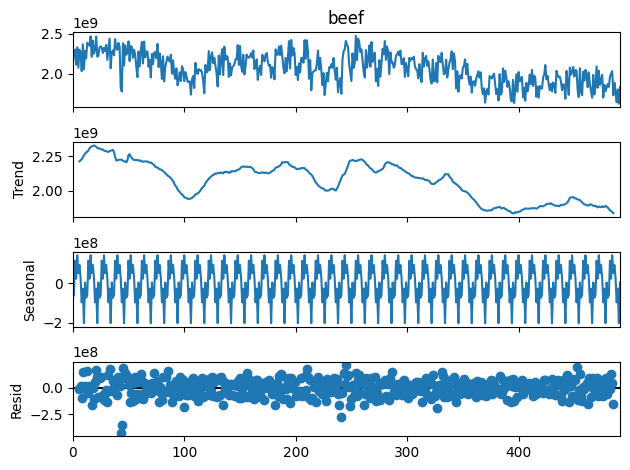

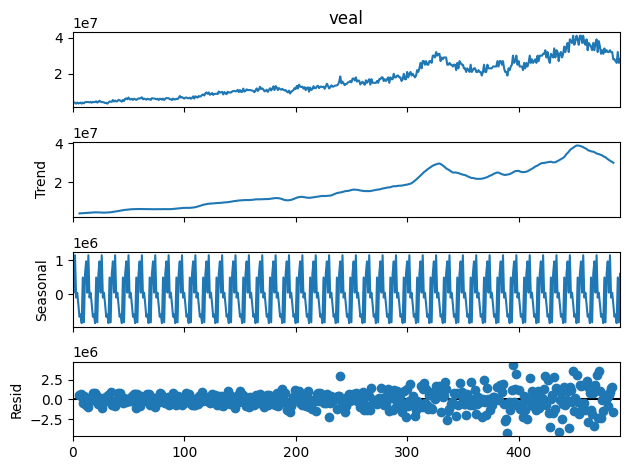

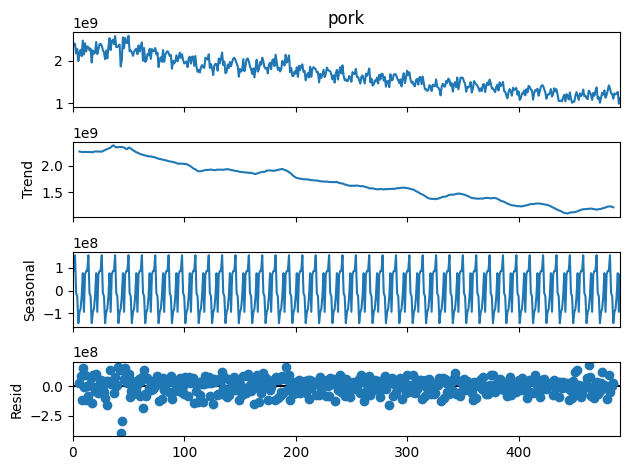

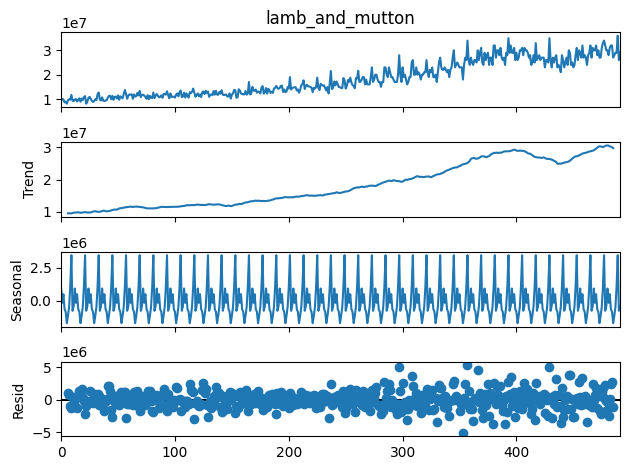

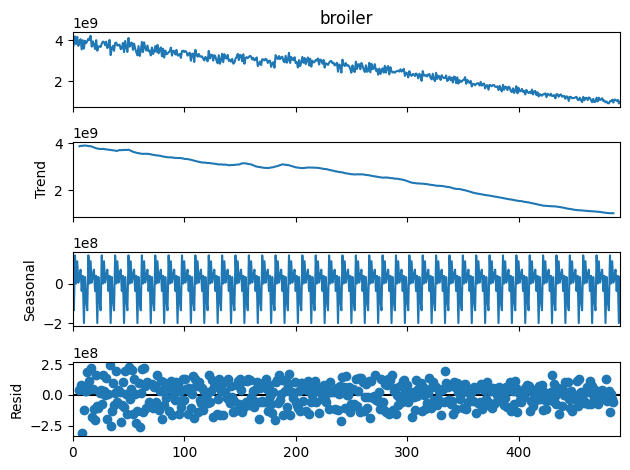

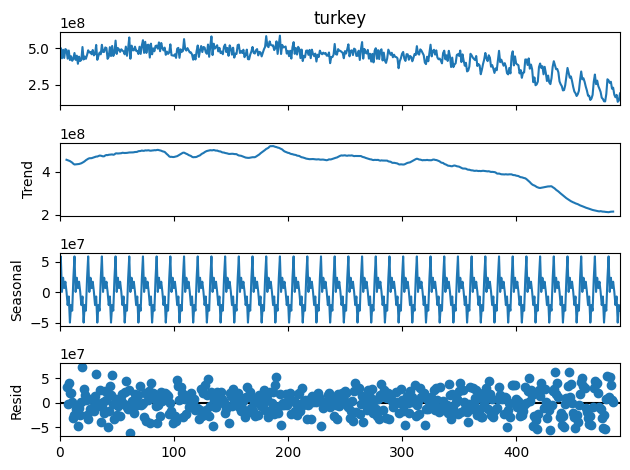

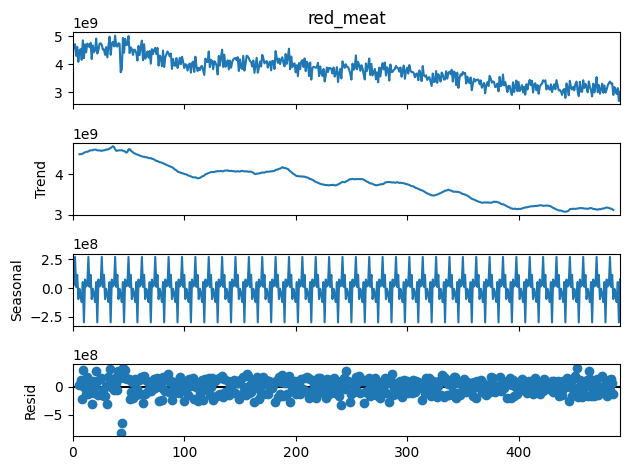

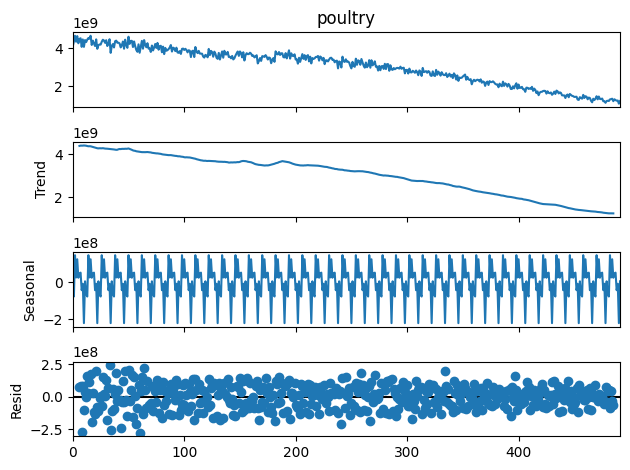

In [46]:
df_subject1_resid = df_subject1.copy()
for meat in MEAT_TYPE:
    decomposition = seasonal_decompose(df_subject1[meat], model='additive', period=12)
    residual = decomposition.resid
    decomposition.plot()
    df_subject1_resid[f'residual_{meat}'] = residual

df_subject1_resid = df_subject1_resid.dropna()
stationary = 0
for meat in MEAT_TYPE:
    if test_stationarity(df_subject1_resid[f'residual_{meat}'], meat):
        stationary += 1
    else:
        print(f'Residual for {meat} is not stationary. Consider differencing or detrending.')
    print('\n')

print(f'Number of stationary residuals: {stationary}/{len(MEAT_TYPE)}')
df_subject1_resid = df_subject1_resid.drop(columns=MEAT_TYPE)
df_subject1_resid

Check if unemployment rates is stationary

In [47]:
test_stationarity(df_subject2[SUBJECT2], SUBJECT2)

Augmented Dickey-Fuller Test Results for Hourly Earnings:
-------------------------------------
Test Statistic: 3.0547
P-value: 1.0000
Number of Lags Used: 14
Number of Observations Used: 202
Critical Values:
    1% (-3.4631)
    5% (-2.8760)
    10% (-2.5745)
Information Criterion (best): -167.0112
Conclusion:
The time series is not stationary. Consider differencing or detrending.


0

Get residual from seasonal trend decomposition

Augmented Dickey-Fuller Test Results for Hourly Earnings:
-------------------------------------
Test Statistic: -6.3341
P-value: 0.0000
Number of Lags Used: 14
Number of Observations Used: 190
Critical Values:
    1% (-3.4652)
    5% (-2.8769)
    10% (-2.5749)
Information Criterion (best): -300.9680
Conclusion:
The time series is stationary with 95% confidence.


,datetime,residual_hourly_earnings
6,2006-09-01,-0.019051
7,2006-10-01,0.084450
8,2006-11-01,-0.026261
9,2006-12-01,0.039989
10,2007-01-01,-0.091064
...,...,...
206,2023-05-01,-0.097878
207,2023-06-01,-0.065795
208,2023-07-01,0.260112
209,2023-08-01,-0.012780


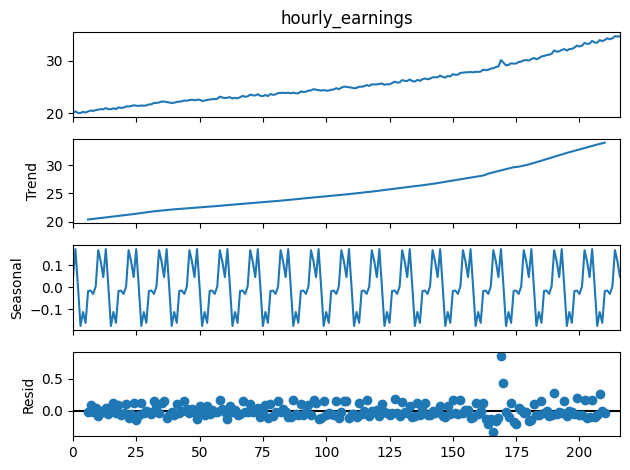

In [48]:
df_subject2_resid = df_subject2.copy()
decomposition = seasonal_decompose(df_subject2[SUBJECT2], model='additive', period=12)
decomposition.plot()
residual = decomposition.resid
df_subject2_resid[f'residual_{SUBJECT2}'] = residual
df_subject2_resid = df_subject2_resid.dropna()
test_stationarity(df_subject2_resid[f'residual_{SUBJECT2}'], SUBJECT2)

df_subject2_resid = df_subject2_resid.drop(columns=[SUBJECT2])
df_subject2_resid

Merge into one dataset for use

In [49]:
common_start = max(df_subject1_resid['datetime'].min(), df_subject2_resid['datetime'].min())
common_end = min(df_subject1_resid['datetime'].max(), df_subject2_resid['datetime'].max())

df_subject1_resid = df_subject1_resid[(df_subject1_resid['datetime'] >= common_start) & (df_subject1_resid['datetime'] <= common_end)]
df_subject2_resid = df_subject2_resid[(df_subject2_resid['datetime'] >= common_start) & (df_subject2_resid['datetime'] <= common_end)]

merged_df = pd.merge(df_subject1_resid, df_subject2_resid, on='datetime')

# Correlation Analysis

Get correlation between the different meat types and subject

/tmp/ipykernel_364311/3716570335.py:6: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(lags, cor, use_line_collection=True)


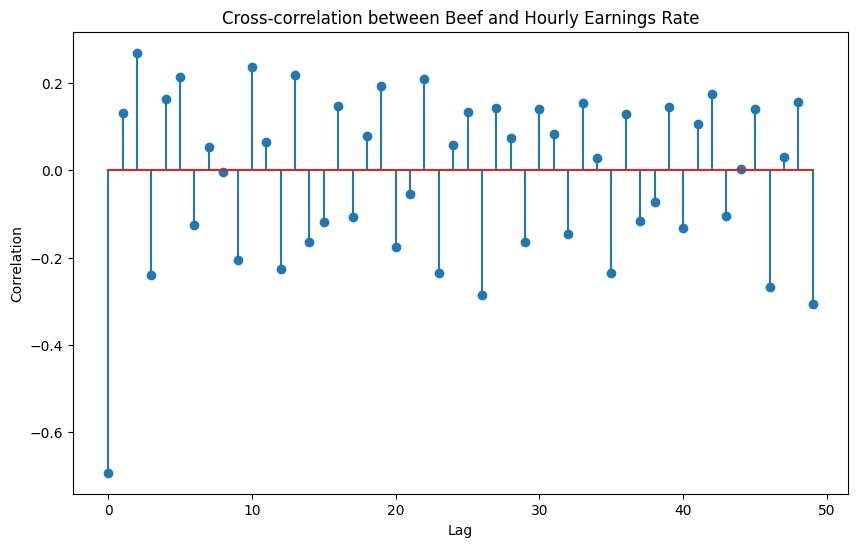

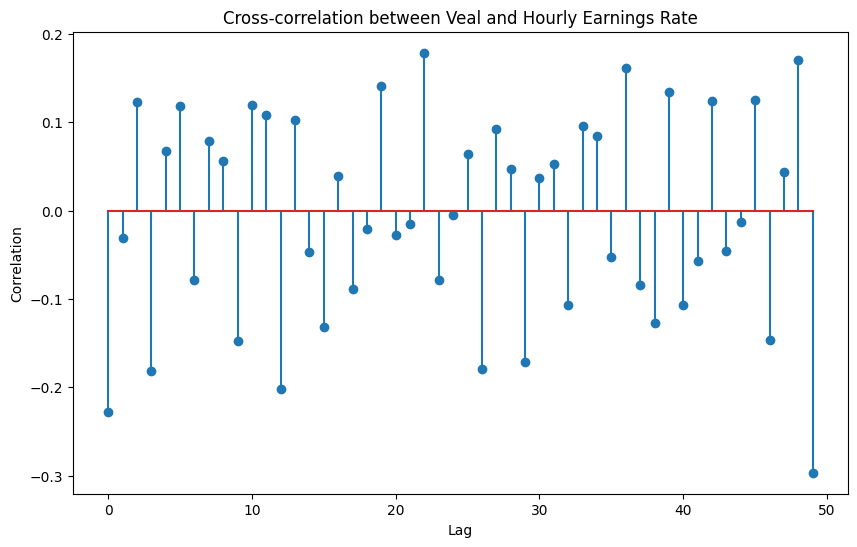

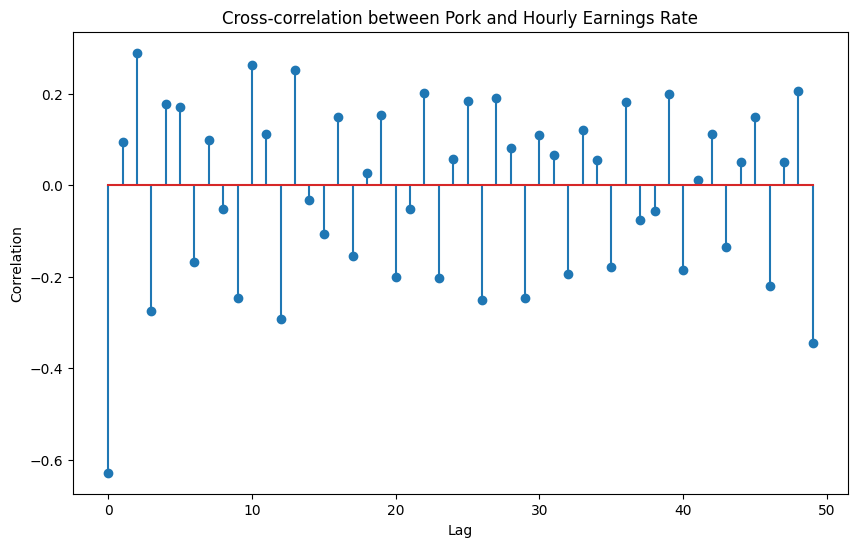

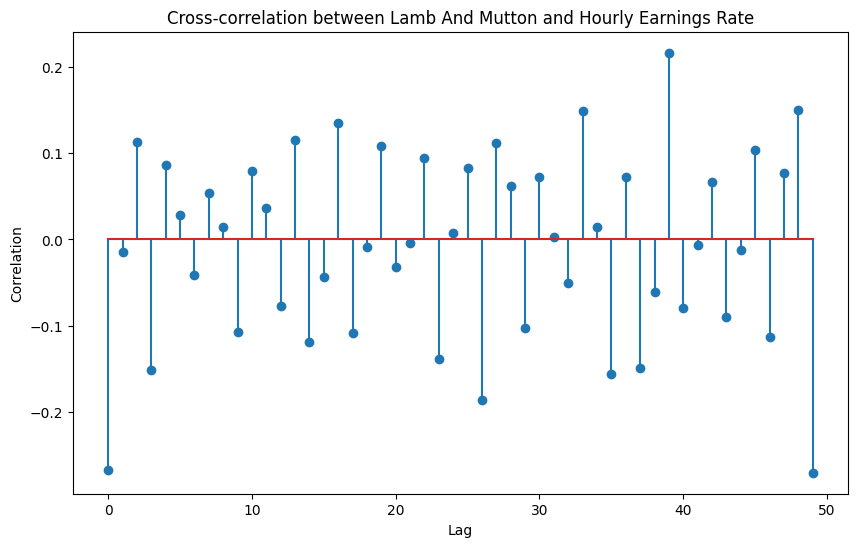

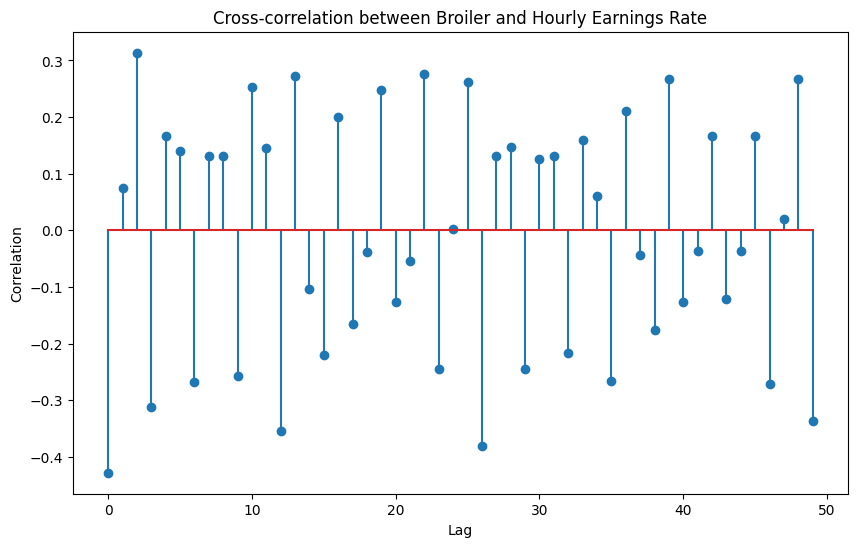

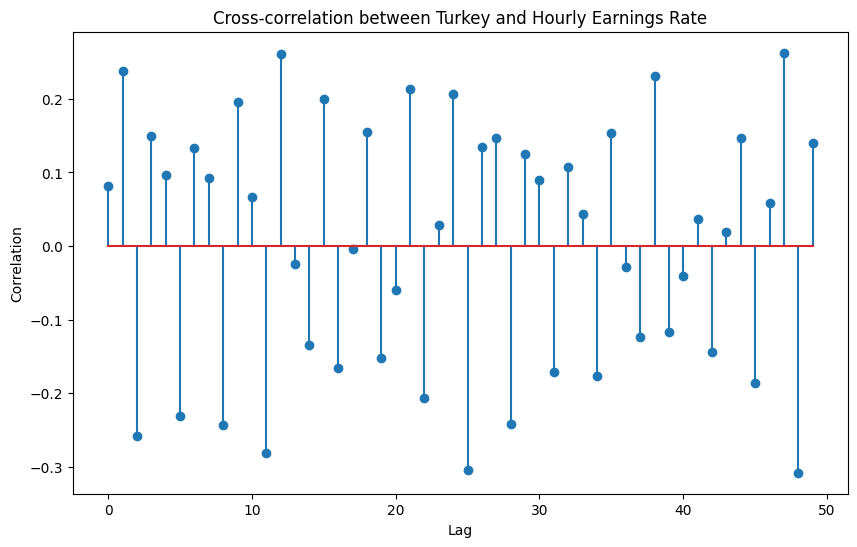

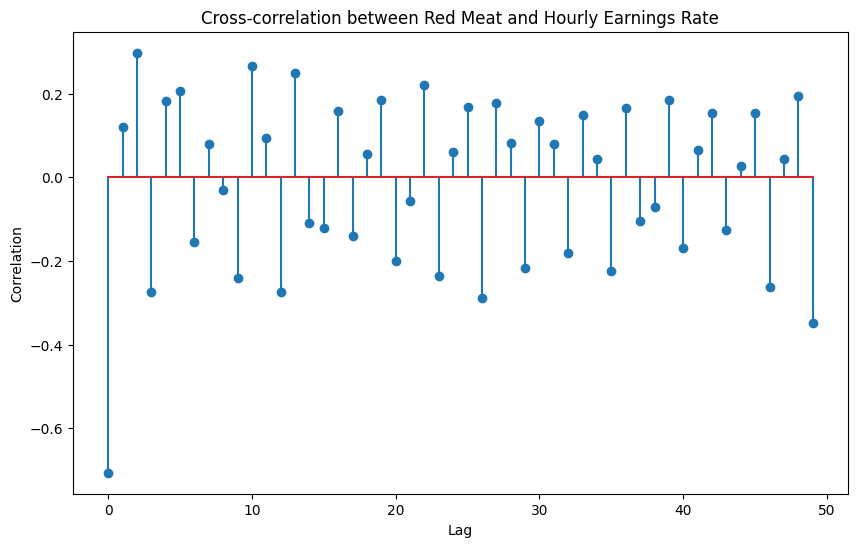

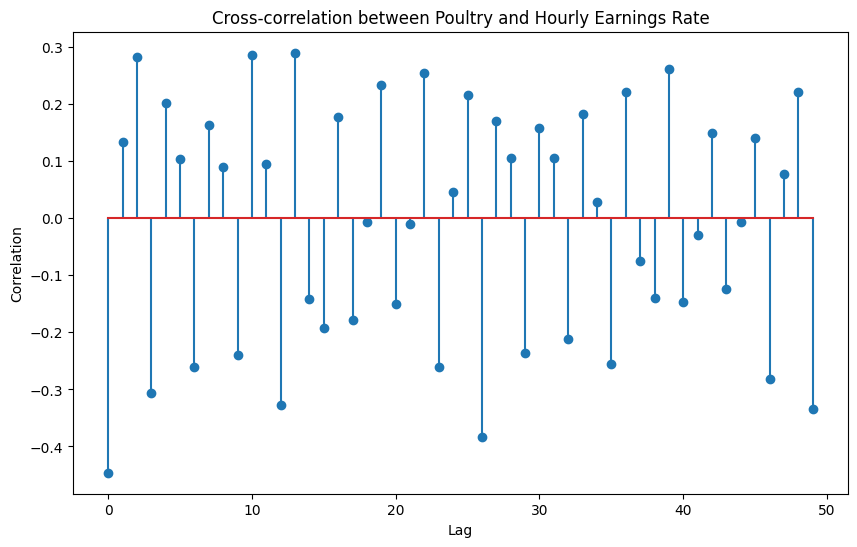

Correlation between Meat Production and Hourly Earnings Rate:
-------------------------------------
Beef: -0.6930, p-value: 0.0000
Veal: -0.2275, p-value: 0.0011
Pork: -0.6281, p-value: 0.0000
Lamb And Mutton: -0.2678, p-value: 0.0001
Broiler: -0.4280, p-value: 0.0000
Turkey: 0.0814, p-value: 0.2496
Red Meat: -0.7064, p-value: 0.0000
Poultry: -0.4460, p-value: 0.0000


In [50]:
for meat in MEAT_TYPE:
    max_lag = 50
    cor = ccf(merged_df[f'residual_{meat}'], merged_df[f'residual_{SUBJECT2}'], adjusted=False)[:max_lag]
    lags = np.arange(max_lag)
    plt.figure(figsize=(10, 6))
    plt.stem(lags, cor, use_line_collection=True)
    plt.title(f"Cross-correlation between {meat.replace('_', ' ').title()} and {SUBJECT_TITLE2} Rate")
    plt.xlabel('Lag')
    plt.ylabel('Correlation')
    plt.show()

# Get correlation between each meat type and subject rate
correlation = {}
for meat in MEAT_TYPE:
    correlation[meat] = stats.pearsonr(merged_df[f'residual_{meat}'], merged_df[f'residual_{SUBJECT2}'])

# Format the correlation values and print them
print(f"Correlation between Meat Production and {SUBJECT_TITLE2} Rate:")
print("-------------------------------------")
for cor in correlation:
    print(f"{cor.replace('_', ' ').title()}: {correlation[cor][0]:.4f}, p-value: {correlation[cor][1]:.4f}")


# (Granger) Causal Analysis

In [51]:
print(MEAT_TYPE)
gc_res = grangercausalitytests(merged_df[[f'residual_{MEAT_TYPE[4]}', f'residual_{SUBJECT2}']], maxlag=12)

['beef', 'veal', 'pork', 'lamb_and_mutton', 'broiler', 'turkey', 'red_meat', 'poultry']

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7245  , p=0.1906  , df_denom=198, df_num=1
ssr based chi2 test:   chi2=1.7506  , p=0.1858  , df=1
likelihood ratio test: chi2=1.7430  , p=0.1868  , df=1
parameter F test:         F=1.7245  , p=0.1906  , df_denom=198, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=9.9855  , p=0.0001  , df_denom=195, df_num=2
ssr based chi2 test:   chi2=20.4832 , p=0.0000  , df=2
likelihood ratio test: chi2=19.5008 , p=0.0001  , df=2
parameter F test:         F=9.9855  , p=0.0001  , df_denom=195, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.4543  , p=0.0003  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=20.0687 , p=0.0002  , df=3
likelihood ratio test: chi2=19.1200 , p=0.0003  , df=3
parameter F test:         F=6.4543  , p=0.0003  , df_denom=192, df_num=3

Grang

# ARIMA

Split train test data

In [52]:
# Flip the dateframe so that the most recent data is at the bottom
model_data = merged_df.iloc[::-1]
model_data.reset_index(drop=True, inplace=True)
model_data.tail(12)

,datetime,residual_beef,residual_veal,residual_pork,residual_lamb_and_mutton,residual_broiler,residual_turkey,residual_red_meat,residual_poultry,residual_hourly_earnings
190,2022-07-01,-1.595919e+08,-76484.375000,-1.401396e+08,8.596094e+05,-1.829977e+08,-1.049016e+07,-2.989483e+08,-1.961254e+08,-0.002805
191,2022-08-01,6.240816e+06,113098.958333,6.555877e+07,1.351589e+06,2.191522e+08,-4.809661e+07,7.326427e+07,1.762546e+08,-0.026113
192,2022-09-01,1.933613e+07,-859.375000,7.177934e+06,3.705469e+05,1.173095e+08,-9.574948e+06,2.688375e+07,1.102808e+08,-0.052384
193,2022-10-01,-4.481377e+07,-981692.708333,-7.976894e+07,-1.327370e+06,4.399108e+07,-1.386318e+07,-1.268918e+08,2.929566e+07,0.193200
194,2022-11-01,1.638886e+08,166848.958333,3.415955e+06,3.559635e+05,1.833988e+08,-2.451297e+07,1.678274e+08,1.584651e+08,-0.075011
195,2022-12-01,-1.271991e+07,-717213.541667,-1.177198e+08,-9.040365e+05,3.103024e+07,-3.083214e+07,-1.320609e+08,-3.567361e+05,-0.072927
196,2023-01-01,1.418061e+07,-404505.208333,9.358991e+07,-1.179948e+05,3.205910e+07,2.164740e+06,1.072480e+08,3.211962e+07,0.169352
197,2023-02-01,3.499462e+06,459348.958333,-9.172587e+06,4.249219e+05,-1.213415e+08,2.009130e+07,-4.788854e+06,-1.040824e+08,-0.113074
198,2023-03-01,1.521037e+08,-416067.708333,1.529559e+08,-1.256016e+06,5.797722e+07,1.957099e+07,3.033875e+08,8.040056e+07,-0.105354
199,2023-04-01,-9.835064e+07,374869.791667,-1.138488e+08,-8.766406e+05,-3.090206e+08,3.953609e+07,-2.127012e+08,-2.739207e+08,0.159205


Do ARIMA for beef in forecasting wages

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.91730D+01    |proj g|=  1.34700D-01

At iterate    5    f=  1.91584D+01    |proj g|=  8.51473D-02

At iterate   10    f=  1.91569D+01    |proj g|=  5.70001D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     18      1     0     0   4.292D-06   1.916D+01
  F =   19.156901893210154     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Figure(1500x1200)


 This problem is unconstrained.


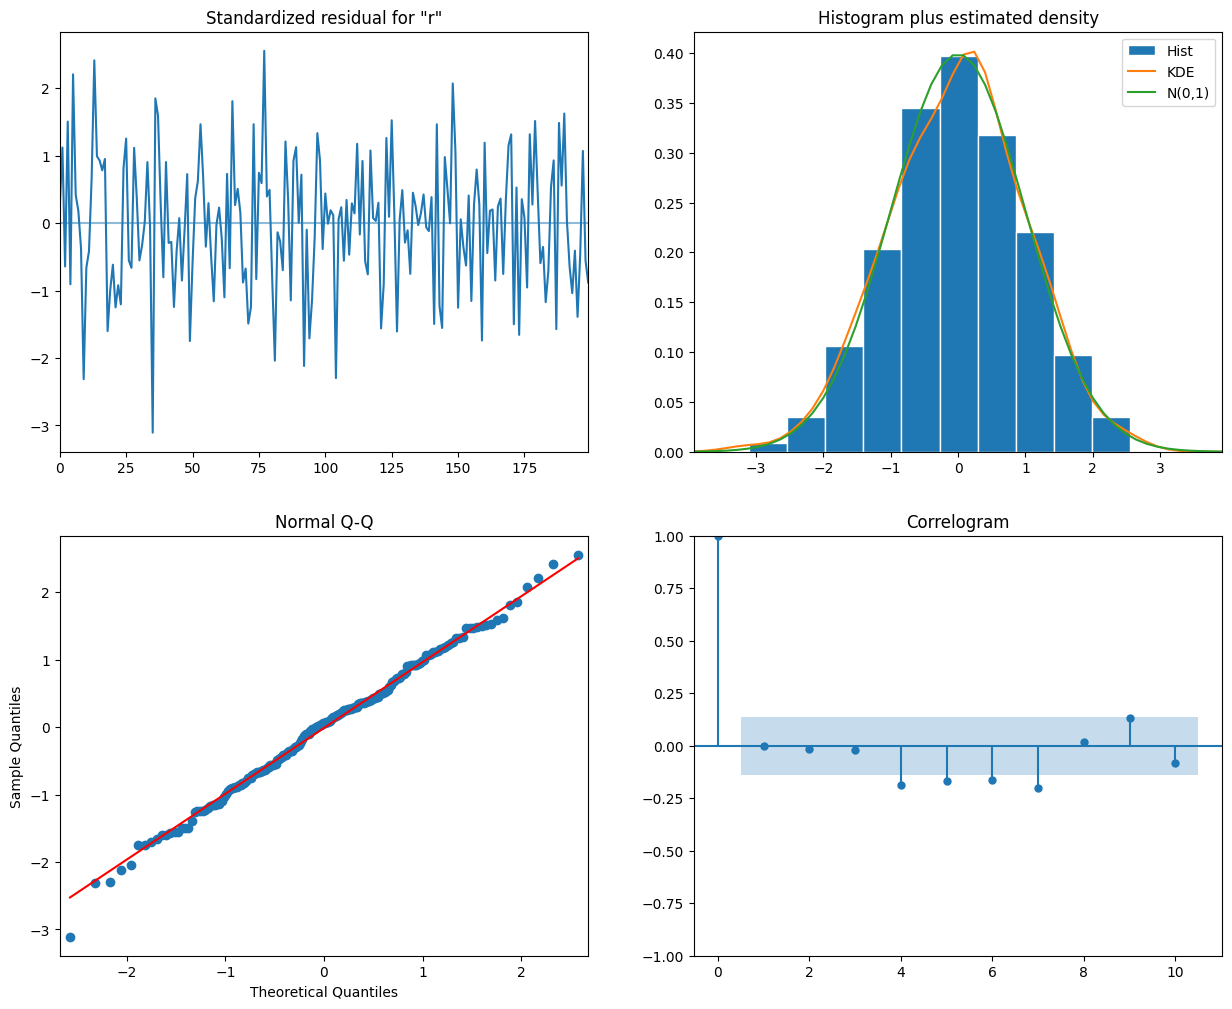

In [53]:
y = merged_df[f'residual_{MEAT_TYPE[0]}']
x = merged_df[f'residual_{SUBJECT2}']

p, d, q = 1, 0, 1
P, D, Q, s = 0, 0, 0, 12

model = SARIMAX(y, exog=x,
                order=(p, d, q),
                seasonal_order=(P, D, Q, s),
                enforce_stationarity=False,
                enforce_invertibility=False)
model_fit = model.fit()
print(model_fit.plot_diagnostics(figsize=(15, 12)))